# Imports

In [2]:

import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import pandas as pd
import re
import os
from scipy.stats import linregress,ttest_ind,ranksums
mimic_extracted_path = "../data/mimic/"
amsterdam_data_path = "../data/amsterdam/"
mimic_base_path = "../../../MIMIC_IV/mimic-iv-1.0/"
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)

# External Validation

## Function declarations

In [24]:
def ece_calculator(X,y,model,plot_bool=False):
    confidences = np.max(model.predict_proba(X),axis=1)
    output_t = np.argmax(model.predict_proba(X),axis=1)

    max_bin = 5

    ECE_arr = np.array([])
    cal_plot_ECE = list([])
    ESCE_arr = np.array([])
    for i in np.arange(0.5,max_bin + 0.1,0.1):
        bins_size = i#1.5
        bin_epsilon = 0.00001
        bin_min = np.round(np.min(confidences*100))

        pred_out = output_t
        real_out = y.values
        bins_correct = plt.hist(confidences[np.where(pred_out==real_out)]*100,density=False,label="Correct pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')#,color="#e898ac",ec='white')
        bins_incorrect = plt.hist(confidences[np.where(pred_out!=real_out)]*100,density=False,label="Incorrect pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')#,color="#e898ac",ec='white')
        

        bin_means = np.array([])
        for b in np.arange(bin_min,101.0,bins_size):
            bin_means = np.append(bin_means,np.array(np.mean(np.append([bin_epsilon],confidences[np.where((confidences > b/100.0)&(confidences <= (b/100.0+bins_size/100.0)))]))))

        bin_means = bin_means[:-1]

        #avg accuracy per bin - avg confidence per bin (summed over all bins and normalized by width of size of bin)
        ECE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (np.abs(bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means)))
        cal_plot_ECE.append(np.array((bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon))))
        ESCE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means))
        ECE_arr = np.append(ECE_arr,np.array(ECE))
        ESCE_arr = np.append(ESCE_arr,np.array(ESCE))

    plt.clf()

    if plot_bool:
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ECE_arr*100,label="avg ECE")
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ESCE_arr*100,label="avg ESCE")

        plt.legend()
        plt.xlabel("Bin size ")
        # plt.xlim([0.5,10])
        plt.ylabel("ECE (% error)")
        plt.show()

        plt.figure(figsize=(12,8))

        bin_min = np.round(np.min(confidences*100))

        mean_sece = np.array([])
        increment_perc = 1
        for perc in np.arange(bin_min+increment_perc,100+increment_perc,increment_perc):
            mean_array = np.array([])
            idx = 0
            for calplots in cal_plot_ECE:
                bins_size = np.arange(0.5,max_bin + 0.1,0.1)[idx]
                plot_arr = np.where(calplots!=0)

                x_ar = (np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2)[plot_arr]
                cal_plot_mean = calplots[plot_arr][np.where((x_ar < perc) & (x_ar >= perc-increment_perc))]
                
                if len(cal_plot_mean>0):
                    temp_mean = np.mean(cal_plot_mean)
                    mean_array = np.append(mean_array,temp_mean)
                
                idx += 1

            mean_sece = np.append(mean_sece,np.mean(mean_array))


        for i in range(len(cal_plot_ECE)):
            bins_size = np.arange(0.5,max_bin + 0.1,0.1)[i]
            x_ar = np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2
            plot_arr = np.where(cal_plot_ECE[i]!=0)
            plt.plot(x_ar[plot_arr],cal_plot_ECE[i][plot_arr]*100,alpha=0.2,color="blue")
        plt.plot(np.arange(bin_min+increment_perc/2,100+increment_perc/2,increment_perc),mean_sece*100,color="red",label="average")
        plt.plot([50,100],[50,100],color="black",label="Perfect calibration")
        plt.xlim([50,100])
        plt.ylim([0,100])
        plt.xticks(np.arange(50,104,5))
        plt.xlabel("Predicted probabilities (%)")
        plt.ylabel("Observed probabilities (%)")
        plt.grid()
        plt.legend()
        plt.show()

    print("ECE normalized AUC (%) = "+str(np.round(np.mean(ECE_arr)*100,2))+" %")
    print("ESCE normalized AUC (%) = "+str(np.round(np.mean(ESCE_arr)*100,2))+" %")

    return np.mean(ECE_arr),np.mean(ESCE_arr)

def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    ECE,ESCE = ece_calculator(X,y,model)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr),ECE,ESCE
                   ]],columns=mimic_result_dataframe_columns)])
    
    return append_df

mimic_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc","ECE","ESCE"]
# mimic_result_dataframe = pd.DataFrame(columns=mimic_result_dataframe_columns)

mimic_p_value_result_dataframe_columns=["model","comparison","AF_group","p_value"]
# mimic_p_value_result_dataframe = pd.DataFrame(columns=mimic_p_value_result_dataframe_columns)

# missing_dataframe = pd.DataFrame(columns=["model","feature","train amst","balanced test amst","all test amst","train mimic","balanced test mimic","all test mimic"])

In [6]:
#mimic_result_dataframe.reset_index(drop=True).to_csv("../results/mimic_af_prediction_results.csv")

In [25]:
#False
#True

one_half_hour_model = True
six_hour_model = False

model_string = ("1.5"*int(one_half_hour_model)+"12"*int(1-one_half_hour_model))*int(1-six_hour_model)+"6"*int(six_hour_model)
print(model_string)

1.5


## Transfer validation

In [26]:
validation_type_string = "transfer"

### Data import

In [27]:
if one_half_hour_model:
    AF_dataset = pd.read_csv(mimic_extracted_path+"AF_dataset_1_5_hours.csv")
else:

    AF_dataset = pd.read_csv(mimic_extracted_path+"AF_dataset_12_hours.csv")

if six_hour_model:
    AF_dataset = pd.read_csv(mimic_extracted_path+"AF_dataset_6_hours.csv")

        
df_patients = pd.read_csv(mimic_extracted_path+"patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

AF_dataset = AF_dataset.merge(df_patients[['patientid','Age']],how='left',on='patientid')


In [28]:
admissions_pd_mimic = pd.read_csv(mimic_extracted_path+"df_adm_icu.csv",sep=',')
admissions_pd_mimic["urgency"]=0
admissions_pd_mimic = admissions_pd_mimic.rename(columns={'stay_id':'admissionid'})
admissions_pd_mimic.loc[admissions_pd_mimic.admission_type.isin(['DIRECT EMER.', 'EW EMER.', 'URGENT']),"urgency"]=1
AF_dataset = AF_dataset.merge(admissions_pd_mimic[["admissionid","ethnicity","urgency"]],how='left',on="admissionid")

In [29]:
AF_dataset["ethnicity_codes"] = 0
for i in range(len(AF_dataset.ethnicity.unique())):
    AF_dataset.loc[AF_dataset.ethnicity.str.contains(AF_dataset.ethnicity.unique()[i]),"ethnicity_codes"]=i

ICD_preadmission_AF_codes = ['I489','I4891','I4821','I480','I481','I4811','I4819','I482','I4820']
diagnoses_icd_df = pd.read_csv("../../../MIMIC_IV/mimic-iv-1.0/"+"hosp/csv/diagnoses_icd.csv")
hadm_id_list_pre_adm_AF = diagnoses_icd_df[diagnoses_icd_df.icd_code.isin(ICD_preadmission_AF_codes)].hadm_id.unique()
AF_dataset["pre_Adm_AF"]=0
AF_dataset.loc[AF_dataset.hadm_id.isin(hadm_id_list_pre_adm_AF),"pre_Adm_AF"]=1


In [30]:
AF_dataset["is_given_NORepinefrine"]=0
AF_dataset.loc[~AF_dataset['mean_NORepinephrine'].isna(),"is_given_NORepinefrine"]=1

AF_dataset["cardiac_surg_bool"]=0
AF_dataset.loc[(AF_dataset["cardiac_bool"]==1)&(AF_dataset["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
if "mean_Calcium Carbonate Suspension" in AF_dataset.columns:
    AF_dataset.loc[(AF_dataset["mean_Calcium Carbonate"]>1)|(AF_dataset["mean_Calcium Gluconate"]>1)|(("mean_Calcium Carbonate Suspension" in AF_dataset.columns)&(AF_dataset["mean_Calcium Carbonate Suspension"]>1))|(AF_dataset["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
else:
    AF_dataset.loc[(AF_dataset["mean_Calcium Carbonate"]>1)|(AF_dataset["mean_Calcium Gluconate"]>1)|(AF_dataset["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset["is_given_Dopamine (Inotropin)"]=0
AF_dataset.loc[~AF_dataset['mean_DOPamine'].isna(),"is_given_Dopamine (Inotropin)"]=1

AF_dataset['is_given_Magnesiumsulfaat (MgSO4)']=0
AF_dataset.loc[~AF_dataset['mean_Magnesium Sulfate'].isna(),'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[~AF_dataset['mean_Propofol'].isna(),'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[~AF_dataset['mean_Fentanyl Citrate'].isna(),'is_given_Fentanyl']=1

AF_dataset["is_given_Furosemide (Lasix)"]=0
AF_dataset.loc[~AF_dataset['mean_Furosemide'].isna(),"is_given_Furosemide (Lasix)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(~AF_dataset['mean_Bumetanide'].isna())|(~AF_dataset['mean_Furosemide'].isna()),"is_given_LoopDiuretics"]=1

AF_dataset["mean_PEEP set"] = AF_dataset["mean_PEEP set"].fillna(0)


In [31]:
#Rename for distr change 12 hour model
AF_dataset = AF_dataset.rename(columns={'mean_PEEP set':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_Foley':'mean_UrineCAD', 'max_Foley':'max_UrineCAD', 
                            'min_Foley':'min_UrineCAD', 'slope_Foley':'slope_UrineCAD', 'max_Central Venous Pressure':'max_CVD','mean_Phosphate':'mean_Fosfaat (bloed)', 'max_Phosphate':'max_Fosfaat (bloed)', 
                            'mean_Lactate':'mean_Lactaat (bloed)','max_Lactate':'max_Lactaat (bloed)','min_Lactate':'min_Lactaat (bloed)',
                            'mean_pH':'mean_pH (bloed)','max_pH':'max_pH (bloed)','min_pH':'min_pH (bloed)',
                            'mean_Arterial Base Excess':'mean_B.E. (bloed)', 'mean_Arterial Blood Pressure systolic':'mean_ABP systolisch',
                            'min_Arterial Base Excess':'min_B.E. (bloed)', 'min_Arterial Blood Pressure systolic':'min_ABP systolisch',
                            'max_Arterial Base Excess':'max_B.E. (bloed)', 'max_Arterial Blood Pressure systolic':'max_ABP systolisch',
                            'slope_Arterial Base Excess':'slope_B.E. (bloed)', 'slope_Arterial Blood Pressure systolic':'slope_ABP systolisch',
                            'mean_Inspired O2 Fraction':'mean_O2 concentratie (Set)','min_Inspired O2 Fraction':'min_O2 concentratie (Set)','max_Inspired O2 Fraction':'max_O2 concentratie (Set)',
                            'mean_Oxygen Saturation':'mean_O2-Saturatie (bloed)','min_Oxygen Saturation':'min_O2-Saturatie (bloed)','max_Oxygen Saturation':'max_O2-Saturatie (bloed)',
                            'min_Propofol':'min_Propofol (Diprivan)', 'min_Fentanyl Citrate':'min_Fentanyl', 'mean_O2 Flow':'mean_O2 l/min', 'cardiac_bool_new':'cardio_surgery_new',
                            'mean_Phosphate':'mean_Fosfaat (bloed)', 'kurt_Central Venous Pressure':'kurt_CVD', 'max_Heart Rate':'max_Hartfrequentie', "max_Platelet Count":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset = AF_dataset.rename(columns={'min_PEEP set':'min_PEEP (Set)','max_PEEP set':'max_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'max_O2 Flow':'max_O2 l/min', 'slope_O2 Flow':'slope_O2 l/min', 
                                                    'cardiac_bool_new':'cardio_surgery_new','min_Phosphate':'min_Fosfaat (bloed)', 
                                                    'min_Arterial Blood Pressure mean': 'min_ABP gemiddeld','max_Arterial Blood Pressure mean': 'max_ABP gemiddeld',
                                                    'slope_Arterial Blood Pressure mean': 'slope_ABP gemiddeld',
                                                    'slope_Bicarbonate':'slope_Act.HCO3 (bloed)','max_Bicarbonate':'max_Act.HCO3 (bloed)','min_Bicarbonate':'min_Act.HCO3 (bloed)',
                                                    'mean_Bicarbonate':'mean_Act.HCO3 (bloed)',
                                                    'mean_Arterial Blood Pressure mean': 'mean_ABP gemiddeld',"slope_Platelet Count":"slope_Thrombo's (bloed)",
                                                    'mean_Central Venous Pressure':'mean_CVD', 'min_Heart Rate':'min_Hartfrequentie', "min_Platelet Count":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'max_O2 Flow':'max_O2 l/min','min_Phosphate':'min_Fosfaat (bloed)','max_Urea Nitrogen':'max_Ureum (bloed)',
                                            'mean_Urea Nitrogen':'mean_Ureum (bloed)','min_Urea Nitrogen':'min_Ureum (bloed)', 'slope_Heart Rate':'slope_Hartfrequentie','mean_Heart Rate':'mean_Hartfrequentie',
                                                    'mean_Central Venous Pressure':'mean_CVD'})

#Rename for standard 12 hour model
AF_dataset = AF_dataset.rename(columns={"mean_Hemoglobin":"mean_Hb (bloed)","slope_pO2":'slope_PO2 (bloed)',"mean_pO2":'mean_PO2 (bloed)',"max_pO2":'max_PO2 (bloed)',
                                        'mean_pCO2':'mean_pCO2 (bloed)','slope_pCO2':'slope_pCO2 (bloed)','min_pCO2':'min_pCO2 (bloed)','max_pCO2':'max_pCO2 (bloed)',
                                        "min_pO2":'min_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'min_O2 Flow':'min_O2 l/min', "mean_Platelet Count":"mean_Thrombo's (bloed)","mean_PTT":"mean_APTT  (bloed)",
                                        'min_Central Venous Pressure':'min_CVD',"min_C-Reactive Protein":"min_CRP (bloed)"})
                                        

In [32]:
AF_dataset = AF_dataset.drop_duplicates("admissionid",keep='first')

In [33]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [34]:
X_train_or = train_AF_dataset
X_test_or = test_AF_dataset
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

### Testing

In [35]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

In [36]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

0:	learn: 0.6879554	total: 1.9ms	remaining: 568ms
100:	learn: 0.5682558	total: 233ms	remaining: 460ms
200:	learn: 0.5513783	total: 446ms	remaining: 220ms
299:	learn: 0.5435235	total: 630ms	remaining: 0us


In [37]:
print("BALANCED TRAIN PATIENTS")
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_train,label=y_train), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_train,CB_AF.predict(X_train)),4)))
print(50*"=")

BALANCED TRAIN PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.70      0.71      4279
          AF       0.71      0.73      0.72      4280

    accuracy                           0.71      8559
   macro avg       0.72      0.71      0.71      8559
weighted avg       0.72      0.71      0.71      8559



AUC = 0.7976
MCC = 0.4302


In [38]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.67      0.69      1070
          AF       0.69      0.73      0.71      1070

    accuracy                           0.70      2140
   macro avg       0.70      0.70      0.70      2140
weighted avg       0.70      0.70      0.70      2140



AUC = 0.7828
MCC = 0.4027


In [39]:
transfer_y_test = y_test
transfer_predict = CB_AF.predict(X_test)

In [40]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.admissionid.isin(AF_0_matched_df.admissionid)))|(AF_dataset.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,mimic_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,mimic_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.69      0.81     49863
          AF       0.05      0.73      0.09      1070

    accuracy                           0.69     50933
   macro avg       0.52      0.71      0.45     50933
weighted avg       0.97      0.69      0.80     50933



AUC = 0.7885
MCC = 0.1302
ECE normalized AUC (%) = 2.16 %
ESCE normalized AUC (%) = -0.97 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.67      0.69      1070
          AF       0.69      0.73      0.71      1070

    accuracy                           0.70      2140
   macro avg       0.70      0.70      0.70      2140
weighted avg       0.70      0.70      0.70      2140



AUC = 0.7828
MCC = 0.4027
ECE normalized AUC (%) = 4.69 %
ESCE normalized AUC (%) = 1.84 %


<Figure size 432x288 with 0 Axes>

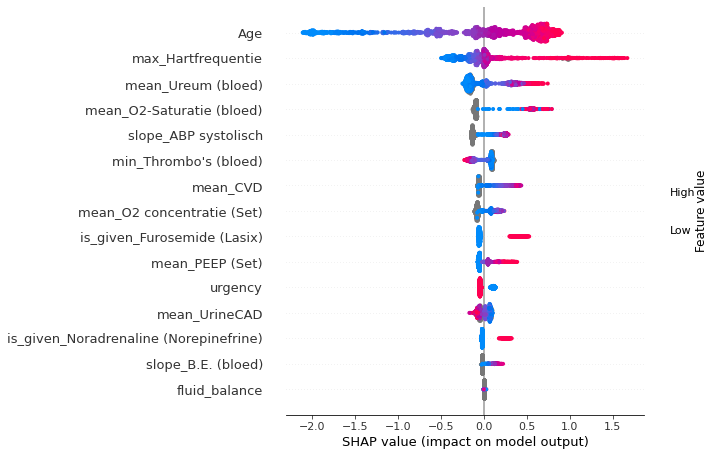

In [41]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test,show=False)

## Combo validation 

In [42]:
validation_type_string = "combo"

### Data Import

In [43]:
if one_half_hour_model:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 

        
df_patients = pd.read_csv(mimic_extracted_path+"patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

AF_dataset_mimic = AF_dataset_mimic.merge(df_patients[['patientid','Age']],how='left',on='patientid')

admissions_pd_mimic = pd.read_csv(mimic_extracted_path+"df_adm_icu.csv",sep=',')
admissions_pd_mimic["urgency"]=0
admissions_pd_mimic = admissions_pd_mimic.rename(columns={'stay_id':'admissionid'})
admissions_pd_mimic.loc[admissions_pd_mimic.admission_type.isin(['DIRECT EMER.', 'EW EMER.', 'URGENT']),"urgency"]=1
AF_dataset_mimic = AF_dataset_mimic.merge(admissions_pd_mimic[["admissionid","ethnicity","urgency"]],how='left',on="admissionid")

In [44]:
AF_dataset_mimic["is_given_NORepinefrine"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_NORepinephrine'].isna(),"is_given_NORepinefrine"]=1

AF_dataset_mimic["cardiac_surg_bool"]=0
AF_dataset_mimic.loc[(AF_dataset_mimic["cardiac_bool"]==1)&(AF_dataset_mimic["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset_mimic["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
if "mean_Calcium Carbonate Suspension" in AF_dataset_mimic.columns:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(("mean_Calcium Carbonate Suspension" in AF_dataset_mimic.columns)&(AF_dataset_mimic["mean_Calcium Carbonate Suspension"]>1))|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
else:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_mimic["is_given_Dopamine (Inotropin)"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_DOPamine'].isna(),"is_given_Dopamine (Inotropin)"]=1

AF_dataset_mimic['is_given_Magnesiumsulfaat (MgSO4)']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Magnesium Sulfate'].isna(),'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset_mimic['is_given_Propofol (Diprivan)']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Propofol'].isna(),'is_given_Propofol (Diprivan)']=1

AF_dataset_mimic['is_given_Fentanyl']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Fentanyl Citrate'].isna(),'is_given_Fentanyl']=1

AF_dataset_mimic["is_given_Furosemide (Lasix)"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Furosemide'].isna(),"is_given_Furosemide (Lasix)"]=1

AF_dataset_mimic["is_given_LoopDiuretics"]=0
AF_dataset_mimic.loc[(~AF_dataset_mimic['mean_Bumetanide'].isna())|(~AF_dataset_mimic['mean_Furosemide'].isna()),"is_given_LoopDiuretics"]=1

AF_dataset_mimic["mean_PEEP set"] = AF_dataset_mimic["mean_PEEP set"].fillna(0)

In [45]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

AF_dataset['is_given_Enoximon (Perfan)']=0
AF_dataset.loc[AF_dataset['mean_Enoximon (Perfan)']>0,'is_given_Enoximon (Perfan)']=1

AF_dataset.loc[AF_dataset['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

AF_dataset['is_given_Hydrocortison (Solu Cortef)']=0
AF_dataset.loc[AF_dataset['mean_Hydrocortison (Solu Cortef)']>0,'is_given_Hydrocortison (Solu Cortef)']=1

AF_dataset['is_given_Midazolam (Dormicum)']=0
AF_dataset.loc[AF_dataset['mean_Midazolam (Dormicum)']>0,'is_given_Midazolam (Dormicum)']=1

AF_dataset['is_given_Morfine']=0
AF_dataset.loc[AF_dataset['mean_Morfine']>0,'is_given_Morfine']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_Fentanyl']>0,'is_given_Fentanyl']=1

In [46]:
AF_dataset.loc[AF_dataset.Age==65,'Age'] = 69
AF_dataset.loc[AF_dataset.Age==35,'Age'] = 39
AF_dataset.loc[AF_dataset.Age==45,'Age'] = 49
AF_dataset.loc[AF_dataset.Age==55,'Age'] = 59
AF_dataset.loc[AF_dataset.Age==79,'Age'] = 79
AF_dataset.loc[AF_dataset.Age==85,'Age'] = 80

In [47]:
#Rename for distr change 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'mean_PEEP set':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_Foley':'mean_UrineCAD', 'max_Foley':'max_UrineCAD', 
                            'min_Foley':'min_UrineCAD', 'slope_Foley':'slope_UrineCAD', 'max_Central Venous Pressure':'max_CVD','mean_Phosphate':'mean_Fosfaat (bloed)', 'max_Phosphate':'max_Fosfaat (bloed)', 
                            'mean_Lactate':'mean_Lactaat (bloed)','max_Lactate':'max_Lactaat (bloed)','min_Lactate':'min_Lactaat (bloed)',
                            'mean_pH':'mean_pH (bloed)','max_pH':'max_pH (bloed)','min_pH':'min_pH (bloed)',
                            'mean_Arterial Base Excess':'mean_B.E. (bloed)', 'mean_Arterial Blood Pressure systolic':'mean_ABP systolisch',
                            'min_Arterial Base Excess':'min_B.E. (bloed)', 'min_Arterial Blood Pressure systolic':'min_ABP systolisch',
                            'max_Arterial Base Excess':'max_B.E. (bloed)', 'max_Arterial Blood Pressure systolic':'max_ABP systolisch',
                            'slope_Arterial Base Excess':'slope_B.E. (bloed)', 'slope_Arterial Blood Pressure systolic':'slope_ABP systolisch',
                            'mean_Inspired O2 Fraction':'mean_O2 concentratie (Set)','min_Inspired O2 Fraction':'min_O2 concentratie (Set)','max_Inspired O2 Fraction':'max_O2 concentratie (Set)',
                            'mean_Oxygen Saturation':'mean_O2-Saturatie (bloed)','min_Oxygen Saturation':'min_O2-Saturatie (bloed)','max_Oxygen Saturation':'max_O2-Saturatie (bloed)',
                            'min_Propofol':'min_Propofol (Diprivan)', 'min_Fentanyl Citrate':'min_Fentanyl', 'mean_O2 Flow':'mean_O2 l/min', 'cardiac_bool_new':'cardio_surgery_new',
                            'mean_Phosphate':'mean_Fosfaat (bloed)', 'kurt_Central Venous Pressure':'kurt_CVD', 'max_Heart Rate':'max_Hartfrequentie', "max_Platelet Count":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'min_PEEP set':'min_PEEP (Set)','max_PEEP set':'max_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'max_O2 Flow':'max_O2 l/min', 'slope_O2 Flow':'slope_O2 l/min', 
                                                    'cardiac_bool_new':'cardio_surgery_new','min_Phosphate':'min_Fosfaat (bloed)', 
                                                    'min_Arterial Blood Pressure mean': 'min_ABP gemiddeld','max_Arterial Blood Pressure mean': 'max_ABP gemiddeld',
                                                    'slope_Arterial Blood Pressure mean': 'slope_ABP gemiddeld',
                                                    'slope_Bicarbonate':'slope_Act.HCO3 (bloed)','max_Bicarbonate':'max_Act.HCO3 (bloed)','min_Bicarbonate':'min_Act.HCO3 (bloed)',
                                                    'mean_Bicarbonate':'mean_Act.HCO3 (bloed)',
                                                    'mean_Arterial Blood Pressure mean': 'mean_ABP gemiddeld',"slope_Platelet Count":"slope_Thrombo's (bloed)",
                                                    'mean_Central Venous Pressure':'mean_CVD', 'min_Heart Rate':'min_Hartfrequentie', "min_Platelet Count":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'max_O2 Flow':'max_O2 l/min','min_Phosphate':'min_Fosfaat (bloed)','max_Urea Nitrogen':'max_Ureum (bloed)',
                                            'mean_Urea Nitrogen':'mean_Ureum (bloed)','min_Urea Nitrogen':'min_Ureum (bloed)', 'slope_Heart Rate':'slope_Hartfrequentie','mean_Heart Rate':'mean_Hartfrequentie',
                                                    'mean_Central Venous Pressure':'mean_CVD'})

#Rename for standard 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={"mean_Hemoglobin":"mean_Hb (bloed)","slope_pO2":'slope_PO2 (bloed)',"mean_pO2":'mean_PO2 (bloed)',"max_pO2":'max_PO2 (bloed)',
                                        'mean_pCO2':'mean_pCO2 (bloed)','slope_pCO2':'slope_pCO2 (bloed)','min_pCO2':'min_pCO2 (bloed)','max_pCO2':'max_pCO2 (bloed)',
                                        "min_pO2":'min_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'min_O2 Flow':'min_O2 l/min', "mean_Platelet Count":"mean_Thrombo's (bloed)","mean_PTT":"mean_APTT  (bloed)",
                                        'min_Central Venous Pressure':'min_CVD',"min_C-Reactive Protein":"min_CRP (bloed)"})

In [48]:
AF_dataset_mimic.loc[:,"min_Ureum (bloed)"] = AF_dataset_mimic["min_Ureum (bloed)"]*0.357
AF_dataset_mimic.loc[:,"mean_O2-Saturatie (bloed)"] = AF_dataset_mimic["mean_O2-Saturatie (bloed)"]/100.0

In [49]:
AF_temp_db_mimic = AF_dataset_mimic[(AF_dataset_mimic.AF==0)&(AF_dataset_mimic.AF_orig==0)&(AF_dataset_mimic.admissionid!=AF_dataset_mimic.date_corresponds_to_AF_admid)]

AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

AF_NOW_mimic = AF_temp_db_mimic.append(AF_dataset_mimic[AF_dataset_mimic.AF==1]).reset_index(drop=True)
AF_NOW = AF_temp_db.append(AF_dataset[AF_dataset.AF==1]).reset_index(drop=True)

In [50]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [51]:
AF_1_df_mimic = AF_dataset_mimic[AF_dataset_mimic.AF==1]
AF_0_matched_df_mimic = AF_dataset_mimic[(AF_dataset_mimic.AF==0)&(AF_dataset_mimic.admissionid!=AF_dataset_mimic.date_corresponds_to_AF_admid)]

train_admissionid_mimic,test_admissionid_mimic = train_test_split(AF_1_df_mimic.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset_mimic = AF_1_df_mimic[AF_1_df_mimic.admissionid.isin(train_admissionid_mimic)]
test_AF_1_dataset_mimic = AF_1_df_mimic[AF_1_df_mimic.admissionid.isin(test_admissionid_mimic)]

train_AF_0_dataset_mimic = AF_0_matched_df_mimic[AF_0_matched_df_mimic.date_corresponds_to_AF_admid.isin(train_AF_1_dataset_mimic.admissionid)]
test_AF_0_dataset_mimic = AF_0_matched_df_mimic[AF_0_matched_df_mimic.date_corresponds_to_AF_admid.isin(test_AF_1_dataset_mimic.admissionid)]

train_AF_dataset_mimic = train_AF_0_dataset_mimic.append(train_AF_1_dataset_mimic).reset_index(drop=True).sample(len(train_AF_0_dataset_mimic)+len(train_AF_1_dataset_mimic),random_state=42)
test_AF_dataset_mimic = test_AF_0_dataset_mimic.append(test_AF_1_dataset_mimic).reset_index(drop=True).sample(len(test_AF_0_dataset_mimic)+len(test_AF_1_dataset_mimic),random_state=42)

In [52]:
mimic_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

mimic_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [53]:
X_train_or_amst = train_AF_dataset
X_test_or_amst = test_AF_dataset
y_train_amst = train_AF_dataset.AF
y_test_amst = test_AF_dataset.AF

X_train_or_mimic = train_AF_dataset_mimic
X_test_or_mimic = test_AF_dataset_mimic
y_train_mimic = train_AF_dataset_mimic.AF
y_test_mimic = test_AF_dataset_mimic.AF

### Testing

In [54]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

X_train_amst = X_train_or_amst[feature_columns]
X_test_amst = X_test_or_amst[feature_columns]
X_train_mimic = X_train_or_mimic[feature_columns]
X_test_mimic = X_test_or_mimic[feature_columns]

X_train = X_train_amst.append(X_train_mimic).reset_index(drop=True).sample(
    len(X_train_amst)+len(X_train_mimic), random_state=42)

y_train = np.append(y_train_amst, y_train_mimic)[X_train.index.values]


In [55]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

0:	learn: 0.6881701	total: 4.13ms	remaining: 1.23s
100:	learn: 0.5710220	total: 286ms	remaining: 564ms
200:	learn: 0.5536886	total: 609ms	remaining: 300ms
299:	learn: 0.5454902	total: 923ms	remaining: 0us


In [56]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.73      0.70      0.72      5879
          AF       0.71      0.74      0.73      5880

    accuracy                           0.72     11759
   macro avg       0.72      0.72      0.72     11759
weighted avg       0.72      0.72      0.72     11759



In [57]:
print("BALANCED TEST AMSTERDAM PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

BALANCED TEST AMSTERDAM PATIENTS
              precision    recall  f1-score   support

       No-AF       0.74      0.69      0.71       400
          AF       0.71      0.76      0.73       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800



AUC = 0.8057
MCC = 0.4485


In [58]:
print("BALANCED TEST MIMIC PATIENTS")
print(classification_report(y_test_mimic,CB_AF.predict(X_test_mimic),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_mimic,label=y_test_mimic), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_mimic,CB_AF.predict(X_test_mimic)),4)))
print(50*"=")

BALANCED TEST MIMIC PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.68      0.69      1070
          AF       0.69      0.72      0.70      1070

    accuracy                           0.70      2140
   macro avg       0.70      0.70      0.70      2140
weighted avg       0.70      0.70      0.70      2140



AUC = 0.7788
MCC = 0.3984


In [59]:
combo_mimic_y_test = y_test_mimic
combo_mimic_predict = CB_AF.predict(X_test_mimic)
combo_amst_y_test = y_test_amst
combo_amst_predict = CB_AF.predict(X_test_amst)

In [60]:
temp_large_db = AF_dataset_mimic[((AF_dataset_mimic.AF==0)&(~AF_dataset_mimic.admissionid.isin(AF_0_matched_df_mimic.admissionid)))|(AF_dataset_mimic.admissionid.isin(test_AF_dataset_mimic.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("all patients mimic",X_test_all_pat,y_test_all_pat,CB_AF,mimic_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_mimic,CB_AF.predict(X_test_mimic),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_mimic,label=y_test_mimic), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_mimic,CB_AF.predict(X_test_mimic)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("balanced test mimic",X_test_mimic,y_test_mimic,CB_AF,mimic_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.70      0.82     49863
          AF       0.05      0.72      0.09      1070

    accuracy                           0.70     50933
   macro avg       0.52      0.71      0.46     50933
weighted avg       0.97      0.70      0.80     50933



AUC = 0.787
MCC = 0.1289
ECE normalized AUC (%) = 1.71 %
ESCE normalized AUC (%) = 0.22 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.68      0.69      1070
          AF       0.69      0.72      0.70      1070

    accuracy                           0.70      2140
   macro avg       0.70      0.70      0.70      2140
weighted avg       0.70      0.70      0.70      2140



AUC = 0.7788
MCC = 0.3984
ECE normalized AUC (%) = 4.54 %
ESCE normalized AUC (%) = 2.08 %


<Figure size 432x288 with 0 Axes>

In [61]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.admissionid.isin(AF_0_matched_df.admissionid)))|(AF_dataset.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("all patients amsterdam",X_test_all_pat,y_test_all_pat,CB_AF,mimic_result_dataframe)


print("BALANCED TEST PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("balanced test amsterdam",X_test_amst,y_test_amst,CB_AF,mimic_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.70      0.82     14563
          AF       0.06      0.76      0.12       400

    accuracy                           0.70     14963
   macro avg       0.53      0.73      0.47     14963
weighted avg       0.97      0.70      0.80     14963



AUC = 0.8078
MCC = 0.1583
ECE normalized AUC (%) = 1.94 %
ESCE normalized AUC (%) = 1.01 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.74      0.69      0.71       400
          AF       0.71      0.76      0.73       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800



AUC = 0.8057
MCC = 0.4485
ECE normalized AUC (%) = 6.0 %
ESCE normalized AUC (%) = 3.96 %


<Figure size 432x288 with 0 Axes>

## Direct validation

In [62]:
validation_type_string = "direct"

### Data Import

In [63]:
if one_half_hour_model:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 


df_patients = pd.read_csv(mimic_extracted_path+"patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

AF_dataset_mimic = AF_dataset_mimic.merge(df_patients[['patientid','Age']],how='left',on='patientid')

admissions_pd_mimic = pd.read_csv(mimic_extracted_path+"df_adm_icu.csv",sep=',')
admissions_pd_mimic["urgency"]=0
admissions_pd_mimic.loc[admissions_pd_mimic.admission_type.isin(['DIRECT EMER.', 'EW EMER.', 'URGENT']),"urgency"]=1
AF_dataset_mimic = AF_dataset_mimic.merge(admissions_pd_mimic[["hadm_id","ethnicity","urgency"]],how='left',on="hadm_id")

In [64]:
AF_dataset_mimic["is_given_NORepinefrine"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_NORepinephrine'].isna(),"is_given_NORepinefrine"]=1

AF_dataset_mimic["cardiac_surg_bool"]=0
AF_dataset_mimic.loc[(AF_dataset_mimic["cardiac_bool"]==1)&(AF_dataset_mimic["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset_mimic["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
if "mean_Calcium Carbonate Suspension" in AF_dataset_mimic.columns:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(("mean_Calcium Carbonate Suspension" in AF_dataset_mimic.columns)&(AF_dataset_mimic["mean_Calcium Carbonate Suspension"]>1))|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
else:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_mimic["is_given_Dopamine (Inotropin)"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_DOPamine'].isna(),"is_given_Dopamine (Inotropin)"]=1

AF_dataset_mimic['is_given_Magnesiumsulfaat (MgSO4)']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Magnesium Sulfate'].isna(),'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset_mimic['is_given_Propofol (Diprivan)']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Propofol'].isna(),'is_given_Propofol (Diprivan)']=1

AF_dataset_mimic['is_given_Fentanyl']=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Fentanyl Citrate'].isna(),'is_given_Fentanyl']=1

AF_dataset_mimic["is_given_Furosemide (Lasix)"]=0
AF_dataset_mimic.loc[~AF_dataset_mimic['mean_Furosemide'].isna(),"is_given_Furosemide (Lasix)"]=1

AF_dataset_mimic["is_given_LoopDiuretics"]=0
AF_dataset_mimic.loc[(~AF_dataset_mimic['mean_Bumetanide'].isna())|(~AF_dataset_mimic['mean_Furosemide'].isna()),"is_given_LoopDiuretics"]=1

AF_dataset_mimic["mean_PEEP set"] = AF_dataset_mimic["mean_PEEP set"].fillna(0)

In [65]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

AF_dataset['is_given_Enoximon (Perfan)']=0
AF_dataset.loc[AF_dataset['mean_Enoximon (Perfan)']>0,'is_given_Enoximon (Perfan)']=1

AF_dataset.loc[AF_dataset['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

AF_dataset['is_given_Hydrocortison (Solu Cortef)']=0
AF_dataset.loc[AF_dataset['mean_Hydrocortison (Solu Cortef)']>0,'is_given_Hydrocortison (Solu Cortef)']=1

AF_dataset['is_given_Midazolam (Dormicum)']=0
AF_dataset.loc[AF_dataset['mean_Midazolam (Dormicum)']>0,'is_given_Midazolam (Dormicum)']=1

AF_dataset['is_given_Morfine']=0
AF_dataset.loc[AF_dataset['mean_Morfine']>0,'is_given_Morfine']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_Fentanyl']>0,'is_given_Fentanyl']=1

In [66]:
AF_dataset.loc[AF_dataset.Age==65,'Age'] = 69
AF_dataset.loc[AF_dataset.Age==35,'Age'] = 39
AF_dataset.loc[AF_dataset.Age==45,'Age'] = 49
AF_dataset.loc[AF_dataset.Age==55,'Age'] = 59
AF_dataset.loc[AF_dataset.Age==79,'Age'] = 79
AF_dataset.loc[AF_dataset.Age==85,'Age'] = 80

In [67]:
#Rename for distr change 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'mean_PEEP set':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_Foley':'mean_UrineCAD', 'max_Foley':'max_UrineCAD', 
                            'min_Foley':'min_UrineCAD', 'slope_Foley':'slope_UrineCAD', 'max_Central Venous Pressure':'max_CVD','mean_Phosphate':'mean_Fosfaat (bloed)', 'max_Phosphate':'max_Fosfaat (bloed)', 
                            'mean_Lactate':'mean_Lactaat (bloed)','max_Lactate':'max_Lactaat (bloed)','min_Lactate':'min_Lactaat (bloed)',
                            'mean_pH':'mean_pH (bloed)','max_pH':'max_pH (bloed)','min_pH':'min_pH (bloed)',
                            'mean_Arterial Base Excess':'mean_B.E. (bloed)', 'mean_Arterial Blood Pressure systolic':'mean_ABP systolisch',
                            'min_Arterial Base Excess':'min_B.E. (bloed)', 'min_Arterial Blood Pressure systolic':'min_ABP systolisch',
                            'max_Arterial Base Excess':'max_B.E. (bloed)', 'max_Arterial Blood Pressure systolic':'max_ABP systolisch',
                            'slope_Arterial Base Excess':'slope_B.E. (bloed)', 'slope_Arterial Blood Pressure systolic':'slope_ABP systolisch',
                            'mean_Inspired O2 Fraction':'mean_O2 concentratie (Set)','min_Inspired O2 Fraction':'min_O2 concentratie (Set)','max_Inspired O2 Fraction':'max_O2 concentratie (Set)',
                            'mean_Oxygen Saturation':'mean_O2-Saturatie (bloed)','min_Oxygen Saturation':'min_O2-Saturatie (bloed)','max_Oxygen Saturation':'max_O2-Saturatie (bloed)',
                            'min_Propofol':'min_Propofol (Diprivan)', 'min_Fentanyl Citrate':'min_Fentanyl', 'mean_O2 Flow':'mean_O2 l/min', 'cardiac_bool_new':'cardio_surgery_new',
                            'mean_Phosphate':'mean_Fosfaat (bloed)', 'kurt_Central Venous Pressure':'kurt_CVD', 'max_Heart Rate':'max_Hartfrequentie', "max_Platelet Count":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'min_PEEP set':'min_PEEP (Set)','max_PEEP set':'max_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'max_O2 Flow':'max_O2 l/min', 'slope_O2 Flow':'slope_O2 l/min', 
                                                    'cardiac_bool_new':'cardio_surgery_new','min_Phosphate':'min_Fosfaat (bloed)', 
                                                    'min_Arterial Blood Pressure mean': 'min_ABP gemiddeld','max_Arterial Blood Pressure mean': 'max_ABP gemiddeld',
                                                    'slope_Arterial Blood Pressure mean': 'slope_ABP gemiddeld',
                                                    'slope_Bicarbonate':'slope_Act.HCO3 (bloed)','max_Bicarbonate':'max_Act.HCO3 (bloed)','min_Bicarbonate':'min_Act.HCO3 (bloed)',
                                                    'mean_Bicarbonate':'mean_Act.HCO3 (bloed)',
                                                    'mean_Arterial Blood Pressure mean': 'mean_ABP gemiddeld',"slope_Platelet Count":"slope_Thrombo's (bloed)",
                                                    'mean_Central Venous Pressure':'mean_CVD', 'min_Heart Rate':'min_Hartfrequentie', "min_Platelet Count":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'max_O2 Flow':'max_O2 l/min','min_Phosphate':'min_Fosfaat (bloed)','max_Urea Nitrogen':'max_Ureum (bloed)',
                                            'mean_Urea Nitrogen':'mean_Ureum (bloed)','min_Urea Nitrogen':'min_Ureum (bloed)', 'slope_Heart Rate':'slope_Hartfrequentie','mean_Heart Rate':'mean_Hartfrequentie',
                                                    'mean_Central Venous Pressure':'mean_CVD'})

#Rename for standard 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={"mean_Hemoglobin":"mean_Hb (bloed)","slope_pO2":'slope_PO2 (bloed)',"mean_pO2":'mean_PO2 (bloed)',"max_pO2":'max_PO2 (bloed)',
                                        'mean_pCO2':'mean_pCO2 (bloed)','slope_pCO2':'slope_pCO2 (bloed)','min_pCO2':'min_pCO2 (bloed)','max_pCO2':'max_pCO2 (bloed)',
                                        "min_pO2":'min_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'min_O2 Flow':'min_O2 l/min', "mean_Platelet Count":"mean_Thrombo's (bloed)","mean_PTT":"mean_APTT  (bloed)",
                                        'min_Central Venous Pressure':'min_CVD',"min_C-Reactive Protein":"min_CRP (bloed)"})

In [68]:
AF_dataset_mimic.loc[:,"min_Ureum (bloed)"] = AF_dataset_mimic["min_Ureum (bloed)"]*0.357
AF_dataset_mimic.loc[:,"mean_O2-Saturatie (bloed)"] = AF_dataset_mimic["mean_O2-Saturatie (bloed)"]/100.0

In [69]:
AF_dataset_mimic = AF_dataset_mimic.drop_duplicates("admissionid")

In [70]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset_amst = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [71]:
AF_1_df_mimic = AF_dataset_mimic[AF_dataset_mimic.AF==1]
AF_0_matched_df_mimic = AF_dataset_mimic[(AF_dataset_mimic.AF==0)&(AF_dataset_mimic.admissionid!=AF_dataset_mimic.date_corresponds_to_AF_admid)]

train_admissionid_mimic,test_admissionid_mimic = train_test_split(AF_1_df_mimic.admissionid.unique(), test_size=0.2, random_state=42)

test_AF_1_dataset_mimic = AF_1_df_mimic[AF_1_df_mimic.admissionid.isin(test_admissionid_mimic)]
test_AF_0_dataset_mimic = AF_0_matched_df_mimic[AF_0_matched_df_mimic.date_corresponds_to_AF_admid.isin(test_AF_1_dataset_mimic.admissionid)]
test_AF_dataset = test_AF_0_dataset_mimic.append(test_AF_1_dataset_mimic).reset_index(drop=True).sample(len(test_AF_0_dataset_mimic)+len(test_AF_1_dataset_mimic),random_state=42)

In [72]:
mimic_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

mimic_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [73]:
X_train_or = train_AF_dataset
X_test_or = test_AF_dataset
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

X_test_or_amst = test_AF_dataset_amst
y_test_amst = test_AF_dataset_amst.AF

### Testing

In [74]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns] 

X_test_amst = X_test_or_amst[feature_columns]

In [75]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

0:	learn: 0.6867133	total: 1.17ms	remaining: 351ms
100:	learn: 0.5384726	total: 136ms	remaining: 268ms
200:	learn: 0.5151898	total: 256ms	remaining: 126ms
299:	learn: 0.5018014	total: 382ms	remaining: 0us


In [76]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_train,label=y_train), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_train,CB_AF.predict(X_train)),4)))
print(50*"=")

              precision    recall  f1-score   support

       No-AF       0.75      0.75      0.75      1600
          AF       0.75      0.75      0.75      1600

    accuracy                           0.75      3200
   macro avg       0.75      0.75      0.75      3200
weighted avg       0.75      0.75      0.75      3200



AUC = 0.8375
MCC = 0.5044


In [77]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.59      0.90      0.71      1070
          AF       0.79      0.38      0.51      1070

    accuracy                           0.64      2140
   macro avg       0.69      0.64      0.61      2140
weighted avg       0.69      0.64      0.61      2140



AUC = 0.7647
MCC = 0.3225


In [78]:
print("BALANCED amst TEST PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

BALANCED amst TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.72      0.74      0.73       400
          AF       0.73      0.71      0.72       400

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



AUC = 0.8123
MCC = 0.4527


In [79]:
direct_y_test = y_test
direct_predict = CB_AF.predict(X_test)
AMST_y_test = y_test_amst
AMST_predict = CB_AF.predict(X_test_amst)

In [81]:
temp_large_db = AF_dataset_mimic[((AF_dataset_mimic.AF==0)&(~AF_dataset_mimic.admissionid.isin(AF_0_matched_df_mimic.admissionid)))|(AF_dataset_mimic.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,mimic_result_dataframe)


print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

mimic_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,mimic_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.90      0.94     49863
          AF       0.07      0.38      0.13      1070

    accuracy                           0.89     50933
   macro avg       0.53      0.64      0.53     50933
weighted avg       0.97      0.89      0.92     50933



AUC = 0.7695
MCC = 0.1296
ECE normalized AUC (%) = 11.59 %
ESCE normalized AUC (%) = 11.56 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.59      0.90      0.71      1070
          AF       0.79      0.38      0.51      1070

    accuracy                           0.64      2140
   macro avg       0.69      0.64      0.61      2140
weighted avg       0.69      0.64      0.61      2140



AUC = 0.7647
MCC = 0.3225
ECE normalized AUC (%) = 8.68 %
ESCE normalized AUC (%) = -8.38 %


<Figure size 432x288 with 0 Axes>

In [82]:
mimic_result_dataframe

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc,ECE,ESCE
0,1.5,transfer,all patients,49863,1070,0.690291,0.732710,0.991759,0.048315,0.814010,0.090652,0.130197,0.788481,0.021650,-0.009692
0,1.5,transfer,balanced test,1070,1070,0.669159,0.732710,0.714571,0.688928,0.691120,0.710145,0.402683,0.782847,0.046946,0.018424
0,1.5,combo,all patients mimic,49863,1070,0.699537,0.715888,0.991360,0.048641,0.820266,0.091093,0.128909,0.786968,0.017059,0.002200
0,1.5,combo,balanced test mimic,1070,1070,0.682243,0.715888,0.705996,0.692586,0.693916,0.704044,0.398356,0.778820,0.045385,0.020813
0,1.5,combo,all patients amsterdam,14563,400,0.698139,0.757500,0.990549,0.064482,0.819028,0.118847,0.158349,0.807825,0.019418,0.010112
0,1.5,combo,balanced test amsterdam,400,400,0.690000,0.757500,0.739946,0.709602,0.714101,0.732769,0.448523,0.805694,0.060028,0.039618
0,1.5,direct,all patients,49863,1070,0.899785,0.378505,0.985395,0.074972,0.940646,0.125155,0.129613,0.769524,0.115914,0.115564
0,1.5,direct,balanced test,1070,1070,0.897196,0.378505,0.590769,0.786408,0.712430,0.511041,0.322472,0.764682,0.086813,-0.083767


In [ ]:
# mimic_result_dataframe.to_csv("../results/mimic_result_dataframe.csv",index=False)

# P-tests

In [79]:
# transfer_y_test = y_test
# transfer_predict = CB_AF.predict(X_test)

# combo_mimic_y_test = y_test_mimic
# combo_mimic_predict = CB_AF.predict(X_test_mimic)
# combo_amst_y_test = y_test_amst
# combo_amst_predict = CB_AF.predict(X_test_amst)

# direct_y_test = y_test
# direct_predict = CB_AF.predict(X_test)
# AMST_y_test = y_test_amst
# AMST_predict = CB_AF.predict(X_test_amst)

In [80]:
#bonferri correction: alpha/m, with m the amount of total tests
from scipy.stats import ranksums

# print("p-value comparisons")
# print(100*"=")
# print("")
    

# print("Direct - Internal")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","all",ranksums(direct_predict,AMST_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","AF",ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","NO AF",ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Combo mimic - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Internal","all",ranksums(combo_mimic_predict,AMST_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Internal","AF",ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Internal","NO AF",ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Combo amst - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","all",ranksums(combo_amst_predict,AMST_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","NO AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Transfer - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","all",ranksums(transfer_predict,AMST_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Transfer - Combo mimic ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,combo_mimic_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_mimic_predict[np.where(combo_mimic_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_mimic_predict[np.where(combo_mimic_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo mimic","all",ranksums(transfer_predict,combo_mimic_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo mimic","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_mimic_predict[np.where(combo_mimic_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo mimic","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_mimic_predict[np.where(combo_mimic_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Transfer - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
# print("")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","all",ranksums(transfer_predict,direct_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])


# print("Combo mimic - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Direct","all",ranksums(combo_mimic_predict,direct_predict)[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Direct","AF",ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=mimic_p_value_result_dataframe_columns)])
mimic_p_value_result_dataframe = pd.concat([mimic_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo mimic - Direct","NO AF",ranksums(combo_mimic_predict[np.where(combo_mimic_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=mimic_p_value_result_dataframe_columns)])



In [190]:
# mimic_p_value_result_dataframe.to_csv("../results/mimic_p_value_result_dataframe.csv",index=False)


# Data description

In [42]:
rename_dict = {'mean_Lactaat (bloed)':'Mean lactate (mmol/L)',
'slope_Hartfrequentie':'Slope heart frequency (bpm)',
'max_Hartfrequentie':'Max heart frequency (bpm)',
'mean_UrineCAD':'Mean hourly urinary volume (mL/h)',
'min_UrineCAD':'Min hourly urinary volume (mL/h)',
'mean_O2-Saturatie (bloed)':'Mean calculated O2 saturation on ABG (%)',
'max_PO2 (bloed)':'Max ABG partial oxygen pressure (mmHg)',
'mean_O2 concentratie (Set)':'Mean ventilator administered FiO2 (%)',
'urgency':'ICU admission Urgency',
"min_Thrombo's (bloed)":'Min thrombocytes (10³/µL)',
'is_given_Noradrenaline (Norepinefrine)':'Has received noradrenalin',
'min_Ureum (bloed)':'Min blood ureum (mmol/L)',
'mean_Ureum (bloed)':'Mean blood ureum (mmol/L)',
'is_given_Furosemide (Lasix)':'Has received loop diuretics',
'min_Act.HCO3 (bloed)':'Min bicarbonate (mmol/L',
'mean_Act.HCO3 (bloed)':'Mean bicarbonate (mmol/L',
'Weight':'Weight (kg)',
'mean_PEEP (Set)':'Mean PEEP setting (mmHg)',
'fluid_balance':'Fluid Balance (mL)',
'mean_CVD':'Mean CVP (mmHg)',
'min_CVD':'Min CVP (mmHg)',
'max_CVD':'Man CVP (mmHg)',
'slope_ABP systolisch':'Slope systolic ABP (mmHg)',
'min_ABP systolisch':'Min systolic ABP (mmHg)',
'min_pH (bloed)':'Min arterial pH on blood gas',
'slope_ABP gemiddeld':'Slope mean ABP (mmHg)',
'min_ABP gemiddeld':'Min mean ABP (mmHg)',
'max_Fosfaat (bloed)':'Max Phosphate (mmol/L)',
'max_ABP systolisch':'Max systolic ABP (mmHg)',
'min_Lactaat (bloed)':'Min Lactate (mmol/L)',
'max_UrineCAD':'Max hourly urinary volume (mL/h)',
'mean_Hartfrequentie':'Mean heart frequency (bpm)',
'min_Fosfaat (bloed)':'Min Phosphate (mmol/L)',
'is_given_Propofol (Diprivan)':'Has received Propofol (Diprivan)',
"max_Thrombo's (bloed)":'Max thrombocytes (10³/µL)',
'slope_B.E. (bloed)':'Slope base excess (mmol/L)'}

X_train_descr = X_train.rename(columns=rename_dict)


if one_half_hour_model:
    describe_df_15_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_no_AF["text"]=describe_df_15_no_AF["mean"].astype(str) +' ('+describe_df_15_no_AF["25%"].astype(str) +" - " + describe_df_15_no_AF["75%"].astype(str) + ")"
    describe_df_15_no_AF = describe_df_15_no_AF[["text"]]
    describe_df_15_no_AF = describe_df_15_no_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_no_AF = describe_df_15_no_AF.rename_axis('Feature').reset_index()

    describe_df_15_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_AF["text"]=describe_df_15_AF["mean"].astype(str) +' ('+describe_df_15_AF["25%"].astype(str) +" - " + describe_df_15_AF["75%"].astype(str) + ")"
    describe_df_15_AF = describe_df_15_AF[["text"]]
    describe_df_15_AF = describe_df_15_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_AF = describe_df_15_AF.rename_axis('Feature').reset_index()

    nans_15_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-1.5_AF"]).rename_axis('Feature').reset_index()
    nans_15_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-1.5_noAF"]).rename_axis('Feature').reset_index()

    nans_15_df = nans_15_AF_df.copy(deep=True)
    nans_15_df["Model-1.5"] = nans_15_noAF_df["Model-1.5_noAF"].astype(str) + " - " +nans_15_AF_df["Model-1.5_AF"].astype(str)
    nans_15_df = nans_15_df[["Feature","Model-1.5"]]
    
    
elif six_hour_model:
    describe_df_6_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_no_AF["text"]=describe_df_6_no_AF["mean"].astype(str) +' ('+describe_df_6_no_AF["25%"].astype(str) +" - " + describe_df_6_no_AF["75%"].astype(str) + ")"
    describe_df_6_no_AF = describe_df_6_no_AF[["text"]]
    describe_df_6_no_AF = describe_df_6_no_AF.rename(columns={"text":"Model-6"})
    describe_df_6_no_AF = describe_df_6_no_AF.rename_axis('Feature').reset_index()

    describe_df_6_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_AF["text"]=describe_df_6_AF["mean"].astype(str) +' ('+describe_df_6_AF["25%"].astype(str) +" - " + describe_df_6_AF["75%"].astype(str) + ")"
    describe_df_6_AF = describe_df_6_AF[["text"]]
    describe_df_6_AF = describe_df_6_AF.rename(columns={"text":"Model-6"})
    describe_df_6_AF = describe_df_6_AF.rename_axis('Feature').reset_index()

    nans_6_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-6_AF"]).rename_axis('Feature').reset_index()
    nans_6_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-6_noAF"]).rename_axis('Feature').reset_index()

    nans_6_df = nans_6_AF_df.copy(deep=True)
    nans_6_df["Model-6"] = nans_6_noAF_df["Model-6_noAF"].astype(str) + " - " +nans_6_AF_df["Model-6_AF"].astype(str)
    nans_6_df = nans_6_df[["Feature","Model-6"]]

else:
    describe_df_12_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_no_AF["text"]=describe_df_12_no_AF["mean"].astype(str) +' ('+describe_df_12_no_AF["25%"].astype(str) +" - " + describe_df_12_no_AF["75%"].astype(str) + ")"
    describe_df_12_no_AF = describe_df_12_no_AF[["text"]]
    describe_df_12_no_AF = describe_df_12_no_AF.rename(columns={"text":"Model-12"})
    describe_df_12_no_AF = describe_df_12_no_AF.rename_axis('Feature').reset_index()

    describe_df_12_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_AF["text"]=describe_df_12_AF["mean"].astype(str) +' ('+describe_df_12_AF["25%"].astype(str) +" - " + describe_df_12_AF["75%"].astype(str) + ")"
    describe_df_12_AF = describe_df_12_AF[["text"]]
    describe_df_12_AF = describe_df_12_AF.rename(columns={"text":"Model-12"})
    describe_df_12_AF = describe_df_12_AF.rename_axis('Feature').reset_index()

    nans_12_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-12_AF"]).rename_axis('Feature').reset_index()
    nans_12_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-12_noAF"]).rename_axis('Feature').reset_index()

    nans_12_df = nans_12_AF_df.copy(deep=True)
    nans_12_df["Model-12"] = nans_12_noAF_df["Model-12_noAF"].astype(str) + " - " +nans_12_AF_df["Model-12_AF"].astype(str)
    nans_12_df = nans_12_df[["Feature","Model-12"]]



In [42]:
if len(describe_df_15_no_AF)*len(describe_df_6_no_AF)*len(describe_df_12_no_AF)>0:
    describe_df_15_AF.merge(describe_df_6_AF,on="Feature",how="outer").merge(describe_df_12_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_AF_mimic.csv",index=False)
    describe_df_15_no_AF.merge(describe_df_6_no_AF,on="Feature",how="outer").merge(describe_df_12_no_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_no_AF_mimic.csv",index=False)

In [43]:
if len(nans_15_df)*len(nans_6_df)*len(nans_12_df)>0:
    nans_15_df.merge(nans_6_df,on="Feature",how="outer").merge(nans_12_df,on="Feature",how="outer").to_csv("../results/nans_MIMIC.csv",index=False)

# Patient Demographics MIMIC 

In [7]:
admissions_pd_mimic = pd.read_csv(mimic_extracted_path+"df_adm_icu.csv",sep=',')
admissions_pd_mimic = admissions_pd_mimic.rename(columns={"subject_id":"patientid","stay_id":"admissionid","los":"lengthofstay"})
admissions_pd_mimic.loc[:,"intime"] = pd.to_datetime(admissions_pd_mimic.intime)
admissions_pd_mimic.loc[:,"outtime"] = pd.to_datetime(admissions_pd_mimic.outtime)
admissions_pd_mimic.loc[:,"lengthofstay"]=admissions_pd_mimic.lengthofstay*24
admissions_pd_mimic.loc[admissions_pd_mimic.AF_measuredat=="0","AF_measuredat"]=0.0
admissions_pd_mimic.loc[admissions_pd_mimic.AF_measuredat!=0,"AF_measuredat"]=(pd.to_datetime(admissions_pd_mimic[admissions_pd_mimic.AF_measuredat!=0].AF_measuredat)-pd.to_datetime(admissions_pd_mimic[admissions_pd_mimic.AF_measuredat!=0].intime)).dt.total_seconds()/60/60
admissions_pd_mimic["AF_measuredat"] = np.float32(admissions_pd_mimic["AF_measuredat"])
admissions_pd_mimic = admissions_pd_mimic[admissions_pd_mimic.lengthofstay>=12]

weight_csv = pd.read_csv(mimic_base_path+"icu/csv/chartevents/"+str(226512)+".csv")[["stay_id","valuenum"]]
weight_csv = weight_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"weight"})
height_csv = pd.read_csv(mimic_base_path+"icu/csv/chartevents/"+str(226730)+".csv")[["stay_id","valuenum"]]
height_csv = height_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"height"})


admissions_pd_mimic = admissions_pd_mimic.merge(height_csv,how='left',on='admissionid')
admissions_pd_mimic.loc[(admissions_pd_mimic.height<50)|(admissions_pd_mimic.height>250)]=int(admissions_pd_mimic[(admissions_pd_mimic.height<50)|(admissions_pd_mimic.height>250)].height.mean())
admissions_pd_mimic = admissions_pd_mimic.merge(weight_csv,how='left',on='admissionid')
admissions_pd_mimic.loc[(admissions_pd_mimic.weight<20)|(admissions_pd_mimic.weight>500)]=int(admissions_pd_mimic[(admissions_pd_mimic.weight<20)|(admissions_pd_mimic.weight>500)].weight.mean())
admissions_pd_mimic["BMI"]=admissions_pd_mimic.weight/((admissions_pd_mimic.height/100)**2)
    
df_patients = pd.read_csv(mimic_base_path+"core/csv/patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

admissions_pd_mimic = admissions_pd_mimic.merge(df_patients[['patientid','Age','gender']],how='left',on='patientid')
#If no gender was specified, the value is -1.
gender_category = {'M':1,"F":0,"":-1}

#Replace the strings with numbers
admissions_pd_mimic["gender"]=admissions_pd_mimic["gender"].replace(gender_category)

admissions_pd_mimic = admissions_pd_mimic[(admissions_pd_mimic.AF==0)|((admissions_pd_mimic.AF==1)&(admissions_pd_mimic.AF_measuredat>=12))]

print(len(admissions_pd_mimic.patientid.unique()))

46234


In [ ]:
mimic_extracted_path = "../data/mimic/"
amsterdam_data_path = "../data/amsterdam/"
mimic_base_path = "../../../MIMIC_IV/mimic-iv-1.0/"

In [10]:
sofa_mimic_csv = pd.read_csv(mimic_base_path+"/extracted/mimic_sofa.csv")[["stay_id","sofa_24hours","starttime","endtime"]]
sofa_mimic_csv = sofa_mimic_csv.rename(columns={"stay_id":"admissionid","sofa_24hours":"sofa"})
sofa_mimic_csv.loc[:,"starttime"]=pd.to_datetime(sofa_mimic_csv.starttime)
sofa_mimic_csv.loc[:,"endtime"]=pd.to_datetime(sofa_mimic_csv.endtime)
sofa_mimic_csv = sofa_mimic_csv.merge(admissions_pd_mimic[["admissionid","patientid","intime","outtime","AF_measuredat","AF"]],how="inner",on="admissionid")
sofa_mimic_csv["time_to_adm"] = (pd.to_datetime(sofa_mimic_csv.starttime)-pd.to_datetime(sofa_mimic_csv.intime)).dt.total_seconds()/60/60
sofa_mean_day_mimic = sofa_mimic_csv[sofa_mimic_csv.time_to_adm<=24][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_mean_day_mimic = sofa_mean_day_mimic.rename(columns={"sofa":"sofa_first24h"})
sofa_AF_mimic = sofa_mimic_csv[(sofa_mimic_csv.AF==1)&(sofa_mimic_csv.AF_measuredat - sofa_mimic_csv.time_to_adm <= 1)&(sofa_mimic_csv.AF_measuredat - sofa_mimic_csv.time_to_adm >= 0)][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_AF_mimic = sofa_AF_mimic.rename(columns={"sofa":"sofa_AF_matched"})
admissions_pd_mimic = admissions_pd_mimic.merge(sofa_mean_day_mimic,how='left',on=['patientid','admissionid'])
admissions_pd_mimic = admissions_pd_mimic.merge(sofa_AF_mimic,how='left',on=['patientid','admissionid'])

In [63]:
AF_dataset.loc[AF_dataset.Weight==0] = AF_dataset[AF_dataset.Weight>0].Weight.mean()
AF_dataset.loc[AF_dataset.Height==0] = AF_dataset[AF_dataset.Height>0].Height.mean()
AF_dataset["BMI"]=AF_dataset.Weight/((AF_dataset.Height/100)**2)
AF_dataset["AF_measuredat"] = AF_dataset["AF_measuredat"]/1000/60/60

print(len(AF_dataset.patientid.unique()))

amst_sofa = pd.read_csv(amsterdam_data_path + "sofa.csv",sep=',')
amst_apache_II = pd.read_csv(amsterdam_data_path + "apache_ii.csv",sep=',')
AF_dataset_demo = AF_dataset.merge(amst_sofa[["admissionid","sofa_total_score"]],how='left',on='admissionid')
AF_dataset_demo = AF_dataset_demo.merge(amst_apache_II[["admissionid","apache_ii_total_score"]],how='left',on='admissionid')

15458


You are merging on int and float columns where the float values are not equal to their int representation


In [32]:
print("total adm MIMIC cohort: \t" + str(len(AF_dataset_mimic.admissionid.unique())))
print("total adm AMST cohort: \t \t" + str(len(AF_dataset.admissionid.unique())))
print("total AF=0 adm MIMIC cohort: \t" + str(len(AF_dataset_mimic[AF_dataset_mimic.AF==0].admissionid.unique())))
print("total AF=0 adm AMST cohort: \t" + str(len(AF_dataset[AF_dataset.AF==0].admissionid.unique())))
print("total AF=1 adm MIMIC cohort: \t" + str(len(AF_dataset_mimic[AF_dataset_mimic.AF==1].admissionid.unique())))
print("total AF=1 adm AMST cohort: \t" + str(len(AF_dataset[AF_dataset.AF==1].admissionid.unique())))


total adm MIMIC cohort: 	59492
total adm AMST cohort: 	 	18163
total AF=0 adm MIMIC cohort: 	54142
total AF=0 adm AMST cohort: 	16163
total AF=1 adm MIMIC cohort: 	5350
total AF=1 adm AMST cohort: 	2000


In [57]:
AF_0_mimic_df = AF_dataset_mimic[AF_dataset_mimic.AF==0].copy(deep=True)
AF_1_mimic_df = AF_dataset_mimic[AF_dataset_mimic.AF==1].copy(deep=True)
AF_0_amst_df = AF_dataset[AF_dataset.AF==0].copy(deep=True)
AF_1_amst_df = AF_dataset[AF_dataset.AF==1].copy(deep=True)

In [39]:
print("AF=1 AMST age: \t" + str(AF_dataset[AF_dataset.AF==1].Age.describe()))
print("AF=0 AMST age: \t" + str(AF_dataset[AF_dataset.AF==0].Age.describe()))

print("AF=1 MIMIC age: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==1].Age.describe()))
print("AF=0 MIMIC age: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==0].Age.describe()))

AF=1 AMST age: 	count    2000.000000
mean       70.754000
std         8.694842
min        39.000000
25%        69.000000
50%        75.000000
75%        75.000000
max        80.000000
Name: Age, dtype: float64
AF=0 AMST age: 	count    16163.000000
mean        63.466683
std         12.623778
min         39.000000
25%         59.000000
50%         69.000000
75%         75.000000
max         80.000000
Name: Age, dtype: float64
AF=1 MIMIC age: 	count    5350.000000
mean       71.037383
std        12.065166
min        18.000000
25%        63.000000
50%        72.000000
75%        80.000000
max        91.000000
Name: Age, dtype: float64
AF=0 MIMIC age: 	count    54142.000000
mean        60.778434
std         16.763337
min         18.000000
25%         50.000000
50%         62.000000
75%         73.000000
max         91.000000
Name: Age, dtype: float64


In [58]:
print("AF=1 AMST BMI: \t" + str(AF_dataset[AF_dataset.AF==1].BMI.describe()))
print("AF=0 AMST BMI: \t" + str(AF_dataset[AF_dataset.AF==0].BMI.describe()))

# print("AF=1 MIMIC age: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==1].Age.describe()))
# print("AF=0 MIMIC age: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==0].Age.describe()))

AF=1 AMST BMI: 	count    1915.000000
mean       26.245304
std         4.492369
min        16.070124
25%        23.875115
50%        24.835646
75%        27.757487
max        43.704475
Name: BMI, dtype: float64
AF=0 AMST BMI: 	count    15302.000000
mean        26.122355
std          4.374049
min         16.070124
25%         23.875115
50%         24.835646
75%         27.757487
max         47.866805
Name: BMI, dtype: float64


In [38]:
print("AF=1 AMST pred_time: \t" + str(AF_dataset[AF_dataset.AF==1].AF_measuredat.describe()/1000/60/60))
print("AF=0 AMST pred_time: \t" + str(AF_dataset[AF_dataset.AF==0].AF_measuredat.describe()/1000/60/60))

print("AF=1 MIMIC pred_time: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==1].AF_measuredat.describe()/60/60))
print("AF=0 MIMIC pred_time: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==0].AF_measuredat.describe()/60/60))

AF=1 AMST pred_time: 	count       0.000556
mean       91.656667
std       144.444795
min        13.566667
25%        31.325000
50%        49.625000
75%        91.250000
max      2164.666667
Name: AF_measuredat, dtype: float64
AF=0 AMST pred_time: 	count       0.004490
mean       49.212791
std        93.845428
min        13.566667
25%        16.000000
50%        21.000000
75%        41.000000
max      2164.666667
Name: AF_measuredat, dtype: float64
AF=1 MIMIC pred_time: 	count       1.486111
mean       64.646423
std        78.562685
min        13.500000
25%        27.201667
50%        43.065694
75%        71.064097
max      1763.700000
Name: AF_measuredat, dtype: float64
AF=0 MIMIC pred_time: 	count      15.039444
mean       46.566120
std        61.647922
min        13.501111
25%        19.000000
50%        27.496111
75%        48.000000
max      1763.700000
Name: AF_measuredat, dtype: float64


In [46]:
print("AF=1 AMST mort: \t" + str(1-AF_dataset[AF_dataset.AF==1].Mortality.describe()))
print("AF=0 AMST mort: \t" + str(1-AF_dataset[AF_dataset.AF==0].Mortality.describe()))

print("AF=1 MIMIC mort: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==1].BMI.describe()))
print("AF=0 MIMIC mort: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==0].BMI.describe()))

AF=1 AMST mort: 	count   -1999.00000
mean        0.46150
std         0.50136
min         1.00000
25%         1.00000
50%         0.00000
75%         0.00000
max         0.00000
Name: Mortality, dtype: float64
AF=0 AMST mort: 	count   -16162.000000
mean         0.718307
std          0.550162
min          1.000000
25%          1.000000
50%          1.000000
75%          0.000000
max          0.000000
Name: Mortality, dtype: float64


In [52]:
print("AF=1 AMST LOS: \t" + str(AF_dataset[AF_dataset.AF==1].lengthofstay.describe()/24))
print("AF=0 AMST LOS: \t" + str(AF_dataset[AF_dataset.AF==0].lengthofstay.describe()/24))

print("AF=1 MIMIC LOS: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==1].lengthofstay.describe()/24))
print("AF=0 MIMIC LOS: \t" + str(AF_dataset_mimic[AF_dataset_mimic.AF==0].lengthofstay.describe()/24))

AF=1 AMST LOS: 	count     83.333333
mean      15.446042
std       18.096344
min        0.666667
25%        3.875000
50%        8.625000
75%       20.385417
max      237.375000
Name: lengthofstay, dtype: float64
AF=0 AMST LOS: 	count    673.458333
mean       3.657154
std        7.386286
min        0.583333
25%        0.875000
50%        1.041667
75%        2.916667
max      202.083333
Name: lengthofstay, dtype: float64
AF=1 MIMIC LOS: 	count    222.916667
mean       7.770783
std        9.879424
min        0.665220
25%        2.926742
50%        4.789132
75%        8.964300
max      375.944560
Name: lengthofstay, dtype: float64
AF=0 MIMIC LOS: 	count    2255.916667
mean        3.323932
std         4.434140
min         0.563356
25%         1.178767
50%         1.950434
75%         3.514210
max       110.232280
Name: lengthofstay, dtype: float64


In [64]:
print("AF=1 AMST SOFA: \t" + str(AF_dataset_demo[AF_dataset_demo.AF==1].sofa_total_score.describe()))
print("AF=0 AMST SOFA: \t" + str(AF_dataset_demo[AF_dataset_demo.AF==0].sofa_total_score.describe()))

AF=1 AMST SOFA: 	count    1915.000000
mean        8.783812
std         3.419052
min         0.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        22.000000
Name: sofa_total_score, dtype: float64
AF=0 AMST SOFA: 	count    15302.000000
mean         5.741341
std          3.357257
min          0.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         23.000000
Name: sofa_total_score, dtype: float64


In [65]:
print("AF=1 AMST apache: \t" + str(AF_dataset_demo[AF_dataset_demo.AF==1].apache_ii_total_score.describe()))
print("AF=0 AMST apache: \t" + str(AF_dataset_demo[AF_dataset_demo.AF==0].apache_ii_total_score.describe()))

AF=1 AMST apache: 	count    1915.000000
mean       22.037859
std         6.769492
min         0.000000
25%        17.000000
50%        21.000000
75%        26.000000
max        45.500000
Name: apache_ii_total_score, dtype: float64
AF=0 AMST apache: 	count    15302.000000
mean        16.600379
std          6.647488
min          0.000000
25%         12.000000
50%         16.000000
75%         20.000000
max         48.500000
Name: apache_ii_total_score, dtype: float64


In [67]:
print("AF=1 AMST Gender: \t" + str(AF_dataset[AF_dataset.AF==1].Gender_category.describe()))
print("AF=0 AMST Gender: \t" + str(AF_dataset[AF_dataset.AF==0].Gender_category.describe()))

AF=1 AMST Gender: 	count    1915.000000
mean        0.625065
std         0.484233
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Gender_category, dtype: float64
AF=0 AMST Gender: 	count    15302.000000
mean         0.651614
std          0.476475
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Gender_category, dtype: float64
